# CityLearn: A Tutorial on Reinforcement Learning Control for Grid-Interactive Efficient Buildings and Communities


In [43]:
!python --version

Python 3.8.20


In [44]:
%%capture

!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install gym==0.21.0 stable-baselines3==1.8.0 CityLearn==2.1.2 \
    ipywidgets matplotlib seaborn shimmy requests beautifulsoup4



In [45]:
import gym
import stable_baselines3
print(gym.__version__)
print(stable_baselines3.__version__)

0.21.0
1.8.0


In [46]:
# System operations
import inspect
import os
import uuid

# Date and time
from datetime import datetime

# type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML
from ipywidgets import IntProgress, Text, VBox

# Data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# CityLearn
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from citylearn.wrappers import TabularQLearningWrapper

# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

In [47]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
%matplotlib inline

In [48]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)

In [49]:
print('All CityLearn datasets:', sorted(DataSet.get_names()))

All CityLearn datasets: ['baeda_3dem', 'citylearn_challenge_2020_climate_zone_1', 'citylearn_challenge_2020_climate_zone_2', 'citylearn_challenge_2020_climate_zone_3', 'citylearn_challenge_2020_climate_zone_4', 'citylearn_challenge_2021', 'citylearn_challenge_2022_phase_1', 'citylearn_challenge_2022_phase_2', 'citylearn_challenge_2022_phase_3', 'citylearn_challenge_2022_phase_all', 'citylearn_challenge_2023_phase_1', 'citylearn_challenge_2023_phase_2_local_evaluation', 'citylearn_challenge_2023_phase_2_online_evaluation_1', 'citylearn_challenge_2023_phase_2_online_evaluation_2', 'citylearn_challenge_2023_phase_2_online_evaluation_3', 'citylearn_challenge_2023_phase_3_1', 'citylearn_challenge_2023_phase_3_2', 'citylearn_challenge_2023_phase_3_3']


In [50]:
root_directory = schema['root_directory']

# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW]
0,7.0,24.0,7.0,0,NaN,NaN,NaN,2.275800,0,0,0,0.0
1,8.0,1.0,1.0,0,NaN,NaN,NaN,0.851167,0,0,0,0.0
2,8.0,2.0,1.0,0,NaN,NaN,NaN,0.834600,0,0,0,0.0
3,8.0,3.0,1.0,0,NaN,NaN,NaN,0.838167,0,0,0,0.0
4,8.0,4.0,1.0,0,NaN,NaN,NaN,1.478433,0,0,0,0.0


In [51]:
display(building_data.describe(include='all'))

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW]
count,8760.000000,8760.000000,8760.000000,8760.0,0.0,0.0,0.0,8760.000000,8760.0,8760.0,8760.0,8760.000000
mean,6.526027,12.500000,3.992466,0.0,NaN,NaN,NaN,1.208145,0.0,0.0,0.0,205.836089
std,3.448048,6.922582,2.003522,0.0,NaN,NaN,NaN,0.968270,0.0,0.0,0.0,290.977786
min,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,0.057000,0.0,0.0,0.0,0.000000
25%,4.000000,6.750000,2.000000,0.0,NaN,NaN,NaN,0.570167,0.0,0.0,0.0,0.000000
50%,7.000000,12.500000,4.000000,0.0,NaN,NaN,NaN,0.812079,0.0,0.0,0.0,0.000000
75%,10.000000,18.250000,6.000000,0.0,NaN,NaN,NaN,1.530529,0.0,0.0,0.0,412.108333
max,12.000000,24.000000,7.000000,0.0,NaN,NaN,NaN,7.987483,0.0,0.0,0.0,976.250000


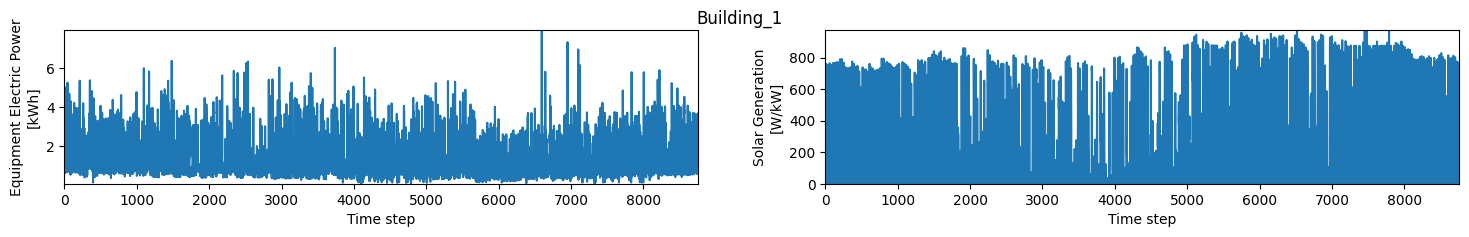

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(18, 2))
x = building_data.index
y1 = building_data['Equipment Electric Power [kWh]']
y2 = building_data['Solar Generation [W/kW]']
axs[0].plot(x, y1)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Equipment Electric Power\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Solar Generation\n[W/kW]')
fig.suptitle(building_name)
plt.show()

In [53]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())

,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],6h Prediction Relative Humidity [%],12h Prediction Relative Humidity [%],24h Prediction Relative Humidity [%],6h Prediction Diffuse Solar Radiation [W/m2],12h Prediction Diffuse Solar Radiation [W/m2],24h Prediction Diffuse Solar Radiation [W/m2],6h Prediction Direct Solar Radiation [W/m2],12h Prediction Direct Solar Radiation [W/m2],24h Prediction Direct Solar Radiation [W/m2]
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


In [54]:
display(weather_data.describe(include='all'))

,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],6h Prediction Relative Humidity [%],12h Prediction Relative Humidity [%],24h Prediction Relative Humidity [%],6h Prediction Diffuse Solar Radiation [W/m2],12h Prediction Diffuse Solar Radiation [W/m2],24h Prediction Diffuse Solar Radiation [W/m2],6h Prediction Direct Solar Radiation [W/m2],12h Prediction Direct Solar Radiation [W/m2],24h Prediction Direct Solar Radiation [W/m2]
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,16.837454,73.004224,208.282192,201.231507,16.837454,16.837454,16.837454,73.004224,73.004224,73.004224,208.282192,208.282192,208.282192,201.231507,201.231507,201.231507
std,3.564816,16.480251,292.799407,296.193301,3.564816,3.564816,3.564816,16.480251,16.480251,16.480251,292.799407,292.799407,292.799407,296.193301,296.193301,296.193301
min,5.600000,10.000000,0.000000,0.000000,5.600000,5.600000,5.600000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.400000,65.000000,0.000000,0.000000,14.400000,14.400000,14.400000,65.000000,65.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.200000,76.000000,10.000000,0.000000,17.200000,17.200000,17.200000,76.000000,76.000000,76.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000
75%,19.400000,84.000000,382.000000,424.000000,19.400000,19.400000,19.400000,84.000000,84.000000,84.000000,382.000000,382.000000,382.000000,424.000000,424.000000,424.000000
max,32.200000,100.000000,1017.000000,953.000000,32.200000,32.200000,32.200000,100.000000,100.000000,100.000000,1017.000000,1017.000000,1017.000000,953.000000,953.000000,953.000000


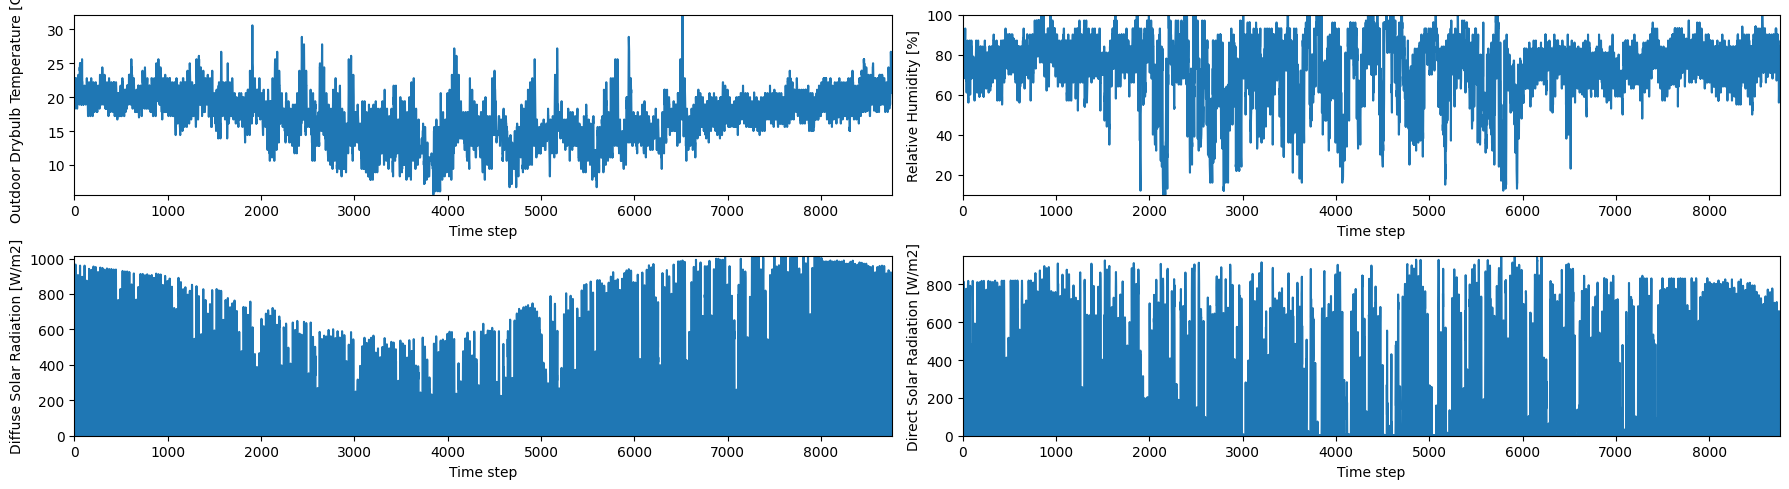

In [55]:
columns = [
    'Outdoor Drybulb Temperature [C]', 'Relative Humidity [%]',
    'Diffuse Solar Radiation [W/m2]', 'Direct Solar Radiation [W/m2]'
]
fig, axs = plt.subplots(2, 2, figsize=(18, 5))
x = weather_data.index

for ax, c in zip(fig.axes, columns):
    y = weather_data[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_ylabel(c)

fig.align_ylabels()
plt.tight_layout()
plt.show()

In [56]:
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())

,Electricity Pricing [$/kWh],6h Prediction Electricity Pricing [$/kWh],12h Prediction Electricity Pricing [$/kWh],24h Prediction Electricity Pricing [$/kWh]
0,0.22,0.22,0.22,0.22
1,0.22,0.22,0.22,0.22
2,0.22,0.22,0.22,0.22
3,0.22,0.22,0.22,0.22
4,0.22,0.22,0.54,0.22


In [57]:
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
display(carbon_intensity_data.head())
display(carbon_intensity_data.describe(include='all').T)

,kg_CO2/kWh
0,0.170724
1,0.157319
2,0.154503
3,0.150945
4,0.151820


,count,mean,std,min,25%,50%,75%,max
kg_CO2/kWh,8760.0,0.156531,0.03537,0.070383,0.13108,0.154263,0.178429,0.281796


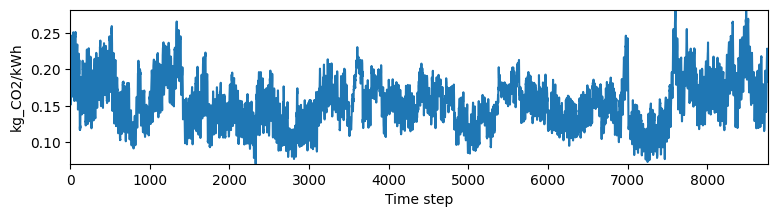

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
x = carbon_intensity_data.index
y = carbon_intensity_data['kg_CO2/kWh']
ax.plot(x, y)
ax.set_xlabel('Time step')
ax.set_ylabel('kg_CO2/kWh')
plt.show()

In [59]:
def set_schema_buildings(
schema: dict, count: int, seed: int
) -> Tuple[dict, List[str]]:
    """Randomly select number of buildings to set as active in the schema.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active buildings set.
    buildings: List[str]
        List of selected buildings.
    """

    assert 1 <= count <= 15, 'count must be between 1 and 15.'

    # set random seed
    np.random.seed(seed)

    # get all building names
    buildings = list(schema['buildings'].keys())

    # remove buildins 12 and 15 as they have pecularities in their data
    # that are not relevant to this tutorial
    buildings_to_exclude = ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    # update schema to only included selected buildings
    for b in schema['buildings']:
        if b in buildings:
            schema['buildings'][b]['include'] = True
        else:
            schema['buildings'][b]['include'] = False

    return schema, buildings

In [60]:
def set_schema_simulation_period(
    schema: dict, count: int, seed: int
) -> Tuple[dict, int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with `simulation_start_time_step`
        and `simulation_end_time_step` key-values set.
    simulation_start_time_step: int
        The first time step in schema time series files to
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total
    # number of available time steps
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    # update schema simulation time steps
    schema['simulation_start_time_step'] = simulation_start_time_step
    schema['simulation_end_time_step'] = simulation_end_time_step

    return schema, simulation_start_time_step, simulation_end_time_step

In [61]:
def set_active_observations(
    schema: dict, active_observations: List[str]
) -> dict:
    """Set the observations that will be part of the environment's
    observation space that is provided to the control agent.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    active_observations: List[str]
        Names of observations to set active to be passed to control agent.

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active observations set.
    """

    active_count = 0

    for o in schema['observations']:
        if o in active_observations:
            schema['observations'][o]['active'] = True
            active_count += 1
        else:
            schema['observations'][o]['active'] = False

    valid_observations = list(schema['observations'].keys())
    assert active_count == len(active_observations),\
        'the provided observations are not all valid observations.'\
          f' Valid observations in CityLearn are: {valid_observations}'

    return schema

# RANDOM SEED SETTINGS

Begin by setting a random seed. You can set the seed to any integer including your birth day, month or year. Perhaps lucky number 😁. Choose wisely because we will use this random seed moving forward 😉?!?):

In [62]:
RANDOM_SEED = 26082003
print('Random seed:', RANDOM_SEED)

Random seed: 26082003


In [63]:
# edit next code line to change number of buildings in simulation
BUILDING_COUNT = 2

 # edit next code line to change number of days in simulation
DAY_COUNT = 7

# edit next code line to change active observations in simulation
ACTIVE_OBSERVATIONS = ['hour']

schema, buildings = set_schema_buildings(schema, BUILDING_COUNT, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, DAY_COUNT, RANDOM_SEED)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

print('Selected buildings:', buildings)
print(
    f'Selected {DAY_COUNT}-day period time steps:',
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Selected buildings: ['Building_1', 'Building_5']
Selected 7-day period time steps: (1344, 1511)
Active observations: ['hour']


In [64]:
schema['central_agent'] = True

# Initialize a CityLearn Environment
***


In [65]:
env = CityLearnEnv(schema)

In [66]:
print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Number of buildings:', len(env.buildings))

Current time step: 0
environment number of time steps: 168
environment uses central agent: True
Number of buildings: 2


In [67]:
# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage capacity history:', {
    b.name: b.electrical_storage.capacity_history[b.time_step] for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage initial_soc:', {
    b.name: b.electrical_storage.initial_soc for b in env.buildings
})
print('Electrical storage soc:', {
    b.name: b.electrical_storage.soc[b.time_step] for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage efficiency history:', {
    b.name: b.electrical_storage.efficiency_history[b.time_step] for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption[b.time_step]
    for b in env.buildings
})
print('Electrical storage capacity loss coefficient:', {
    b.name: b.electrical_storage.capacity_loss_coefficient for b in env.buildings
})
print()
# pv
print('PV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})
print()

# active observations and actions
with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.width', None
):
    print('Active observations:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.observation_metadata}
        for b in env.buildings
    ]))
    print()
    print('Active actions:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.action_metadata}
        for b in env.buildings
    ]))

Electrical storage capacity: {'Building_1': 6.4, 'Building_5': 6.4}
Electrical storage nominal power: {'Building_1': 5.0, 'Building_5': 5.0}
Electrical storage capacity history: {'Building_1': 6.4, 'Building_5': 6.4}
Electrical storage loss_coefficient: {'Building_1': 0.0, 'Building_5': 0.0}
Electrical storage initial_soc: {'Building_1': 0.0, 'Building_5': 0.0}
Electrical storage soc: {'Building_1': 0.0, 'Building_5': 0.0}
Electrical storage efficiency: {'Building_1': 0.9, 'Building_5': 0.9}
Electrical storage efficiency history: {'Building_1': 0.9, 'Building_5': 0.9}
Electrical storage electricity consumption: {'Building_1': 0.0, 'Building_5': 0.0}
Electrical storage capacity loss coefficient: {'Building_1': 1e-05, 'Building_5': 1e-05}

PV nominal power: {'Building_1': 4.0, 'Building_5': 4.0}

Active observations:


,building,month,day_type,hour,daylight_savings_status,outdoor_dry_bulb_temperature,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h,carbon_intensity,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,solar_generation,cooling_storage_soc,heating_storage_soc,dhw_storage_soc,electrical_storage_soc,net_electricity_consumption,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h,power_outage
0,Building_1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Building_5,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False



Active actions:


,building,cooling_storage,heating_storage,dhw_storage,electrical_storage
0,Building_1,False,False,False,True
1,Building_5,False,False,False,True


In [68]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = {
        'electricity_consumption_total': 'Consumption',
        'cost_total': 'Cost',
        'carbon_emissions_total': 'Emissions',
        'daily_peak_average': 'Avg. daily peak',
        'ramping_average': 'Ramping',
        'monthly_one_minus_load_factor_average': '1 - load factor'
    }
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()
    kpis['cost_function'] = kpis['cost_function'].map(lambda x: kpi_names[x])

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)

    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

In [69]:
def plot_building_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        for p in ax.patches:
            ax.text(
                p.get_x() + p.get_width(),
                p.get_y() + p.get_height()/2.0,
                p.get_width(), ha='left', va='center'
            )

    # plt.tight_layout()
    return fig

In [70]:
def plot_district_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width(),
            p.get_y() + p.get_height()/2.0,
            p.get_width(), ha='left', va='center'
        )

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

In [71]:
def plot_building_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.buildings[i].net_electricity_consumption
            x = range(len(y))
            ax.plot(x, y, label=k)

        y = v.buildings[i].net_electricity_consumption_without_storage
        ax.plot(x, y, label='Baseline')
        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [72]:
def plot_district_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots district-level net electricty consumption profile
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.net_electricity_consumption
        x = range(len(y))
        ax.plot(x, y, label=k)

    y = v.net_electricity_consumption_without_storage
    ax.plot(x, y, label='Baseline')
    ax.set_xlabel('Time step')
    ax.set_ylabel('kWh')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)

    plt.tight_layout()
    return fig

In [73]:
def plot_battery_soc_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            soc = np.array(v.buildings[i].electrical_storage.soc)
            capacity = v.buildings[i].electrical_storage.capacity_history[0]
            y = soc/capacity
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)


    plt.tight_layout()

    return fig

In [74]:
def plot_simulation_summary(envs: Mapping[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.
    """

    _ = plot_building_kpis(envs)
    print('Building-level KPIs:')
    plt.show()
    _ = plot_building_load_profiles(envs)
    print('Building-level load profiles:')
    plt.show()
    _ = plot_battery_soc_profiles(envs)
    print('Battery SoC profiles:')
    plt.show()
    _ = plot_district_kpis(envs)
    print('District-level KPIs:')
    plt.show()
    print('District-level load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

# Custom Rule-Based Controller
---



In [75]:
rbc_env = CityLearnEnv(schema)

In [76]:
class CustomRBC(HourRBC):
   def __init__(
       self, env: CityLearnEnv, action_map: Mapping[int, float] = None,
       loader: IntProgress = None
    ):
      r"""Initialize CustomRBC.

      Parameters
      ----------
      env: Mapping[str, CityLearnEnv]
         CityLearn environment instance.
      action_map: Mapping[int, float]
         Mapping of hour to control action.
      loader: IntProgress
         Progress bar.
      """

      super().__init__(env=env, action_map=action_map)
      self.loader = loader

   def next_time_step(self):
      r"""Advance to next `time_step`."""

      super().next_time_step()

      if self.loader is not None:
         self.loader.value += 1
      else:
         pass

In [77]:
action_map = {i: 0.0 for i in range(1, 25)}
rbc_model = CustomRBC(env=rbc_env, action_map=action_map)
print('default RBC action map:', action_map)

default RBC action map: {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0}


In [78]:
def get_loader(**kwargs):
    """Returns a progress bar"""

    kwargs = {
        'value': 0,
        'min': 0,
        'max': 10,
        'description': 'Simulating:',
        'bar_style': '',
        'style': {'bar_color': 'maroon'},
        'orientation': 'horizontal',
        **kwargs
    }
    return IntProgress(**kwargs)

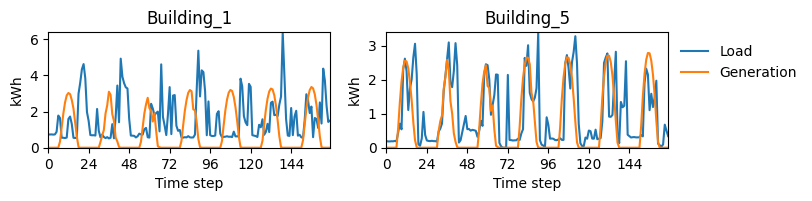

HTML(value='\n<h1>Custom RBC Tuner</h1>\n<p>Use this interactive widget to tune your custom RBC!\nReference th…

IntProgress(value=0, description='Waiting', max=10, style=ProgressStyle(bar_color='maroon'))

In [79]:
action_step = 0.05
hour_step = 2
hours = list(range(1, 25, hour_step))
default_loader_description = 'Waiting'
questions = """
<h1>Custom RBC Tuner</h1>
<p>Use this interactive widget to tune your custom RBC!
Reference the building load profiles above and the questions below when
deciding on how to charge/discharge your rule-based controlled batteries.</p>

<h3>Some considerations when tuning your custom RBC:</h3>
<ul>
    <li>What happens when actions for all hours are set to 0?</li>
    <li>How can we set the RBC so that it takes advantage
    of solar generation?</li>
    <li>Can you spot the duck curve?</li>
    <li>What settings work best for a specific building?</li>
    <li>What settings work best for the entire district?</li>
    <li>Can you tune the RBC to target improvements in any one of
    the evaluation KPIs?</li>
    <li>What challenges can you identify from this RBC tuning process?</li>
</ul>

<h3>Interact with the controls to tune your RBC:</h3>

<p>Use the sliders to set the hourly charge and discharge rate
of the batteries. Positive values indicate charging
and negative values indicate discharging the batteries</p>
"""
html_ui = HTML(value=questions, placeholder='Questions')
sliders = [FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=action_step,
    description=f'Hr: {h}-{h + hour_step - 1}',
    disabled=False,
    continuous_update=False,
    orientation='vertical',
    readout=True,
    readout_format='.2f',
) for h in hours]
reset_button = Button(
    description='Reset', disabled=False, button_style='info',
    tooltip='Set all hour actions to 0.0', icon=''
)
random_button = Button(
    description='Random', disabled=False, button_style='warning',
    tooltip='Select random hour actions', icon=''
)
simulate_button = Button(
    description='Simulate', disabled=False, button_style='success',
    tooltip='Run simulation', icon='check'
)
sliders_ui = HBox(sliders)
buttons_ui = HBox([reset_button, random_button, simulate_button])

# run simulation so that the environment has results
# even if user does not interact with widgets
sac_episodes = 1
rbc_model.learn(episodes=sac_episodes)

loader = get_loader(description=default_loader_description)

def plot_building_guide(env):
    """Plots building load and generation profiles."""

    column_count_limit = 4
    building_count = len(env.buildings)
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.5*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, (ax, b) in enumerate(zip(fig.axes, env.buildings)):
        y1 = b.energy_simulation.non_shiftable_load
        y2 = b.pv.get_generation(b.energy_simulation.solar_generation)
        x = range(len(y1))
        ax.plot(x, y1, label='Load')
        ax.plot(x, y2, label='Generation')
        ax.set_title(b.name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

    return fig

def on_reset_button_clicked(b):
    """Zeros sliders and loader values."""

    loader.value = 0
    loader.description = default_loader_description

    for s in sliders:
        s.value = 0.0

def on_random_button_clicked(b):
    """Zeros loader value and sets sliders to random values."""

    loader.value = 0
    loader.description = default_loader_description
    options = np.arange(-1.0, 1.0, action_step)

    for s in sliders:
        s.value = round(random.choice(options), 2)

def on_simulate_button_clicked(b):
    """Runs RBC simulation using selected action map."""

    loader.description = 'Simulating'
    loader.value = 0
    clear_output(wait=False)

    # plot building profiles
    _ = plot_building_guide(rbc_env)
    plt.show()

    display(html_ui, sliders_ui, buttons_ui, loader)
    reset_button.disabled = True
    random_button.disabled = True
    simulate_button.disabled = True

    for s in sliders:
        s.disabled = True

    action_map = {}

    for h, s in zip(hours, sliders):
        for i in range(hour_step):
            action_map[h + i] = s.value

    loader.max = rbc_env.time_steps*sac_episodes
    rbc_model.action_map = action_map
    rbc_model.learn(episodes=sac_episodes)

    loader.description = 'Finished'
    plot_simulation_summary({'RBC': rbc_env})

    reset_button.disabled = False
    random_button.disabled = False
    simulate_button.disabled = False

    for s in sliders:
        s.disabled = False

reset_button.on_click(on_reset_button_clicked)
random_button.on_click(on_random_button_clicked)
simulate_button.on_click(on_simulate_button_clicked)

# plot building profiles
_ = plot_building_guide(rbc_env)
plt.show()

# preview of building load profile
display(html_ui, sliders_ui, buttons_ui, loader)

# Tabular Q-Learning Algorithm as an Adaptive Controller
---


In [80]:
tql_env = CityLearnEnv(schema)

In [81]:
# define active observations and actions and their bin sizes
observation_bins = {'hour': 24}
action_bins = {'electrical_storage': 12}

# initialize list of bin sizes where each building
# has a dictionary in the list definining its bin sizes
observation_bin_sizes = []
action_bin_sizes = []

for b in tql_env.buildings:
    # add a bin size definition for the buildings
    observation_bin_sizes.append(observation_bins)
    action_bin_sizes.append(action_bins)

In [82]:
tql_env = TabularQLearningWrapper(
    tql_env.unwrapped,
    observation_bin_sizes=observation_bin_sizes,
    action_bin_sizes=action_bin_sizes
)

In [83]:
class CustomTabularQLearning(TabularQLearning):
    def __init__(
        self, env: CityLearnEnv, loader: IntProgress,
        random_seed: int = None, **kwargs
    ):
        r"""Initialize CustomRBC.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        random_seed: int
            Random number generator reprocucibility seed for
            eqsilon-greedy action selection.
        kwargs: dict
            Parent class hyperparameters
        """

        super().__init__(env=env, random_seed=random_seed, **kwargs)
        self.loader = loader
        self.reward_history = []

    def next_time_step(self):
        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.loader.value += 1
        super().next_time_step()

In [84]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
i = 3
m = tql_env.observation_space[0].n
n = tql_env.action_space[0].n
t = tql_env.time_steps - 1
tql_episodes = m*n*i/t
tql_episodes = int(tql_episodes)
print('Q-Table dimension:', (m, n))
print('Number of episodes to train:', tql_episodes)

# ------------------------------- SET LOADER ------------------------------
loader = get_loader(max=tql_episodes*t)
display(loader)

# ----------------------- SET MODEL HYPERPARAMETERS -----------------------
tql_kwargs = {
    'epsilon': 1.0,
    'minimum_epsilon': 0.01,
    'epsilon_decay': 0.0001,
    'learning_rate': 0.005,
    'discount_factor': 0.99,
}

# ----------------------- INITIALIZE AND TRAIN MODEL ----------------------
tql_model = CustomTabularQLearning(
    env=tql_env,
    loader=loader,
    random_seed=RANDOM_SEED,
    **tql_kwargs
)
_ = tql_model.learn(episodes=tql_episodes)

Q-Table dimension: (24, 144)
Number of episodes to train: 62


IntProgress(value=0, description='Simulating:', max=10354, style=ProgressStyle(bar_color='maroon'))

In [85]:
import gymnasium
import gym
print(gymnasium.__version__)
print(gym.__version__)

1.0.0
0.21.0


Building-level KPIs:


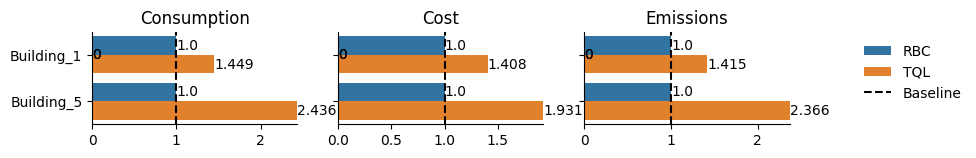

Building-level load profiles:


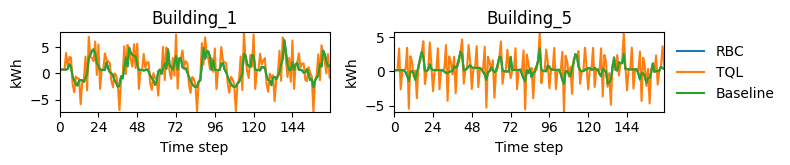

Battery SoC profiles:


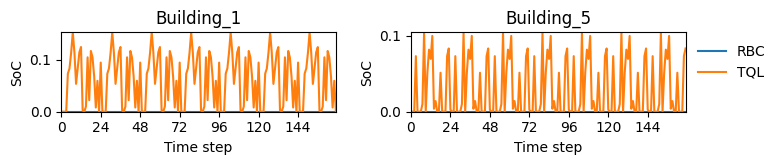

District-level KPIs:


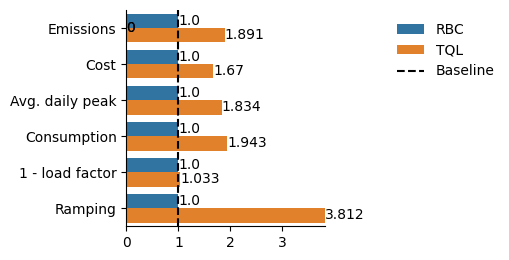

District-level load profiles:


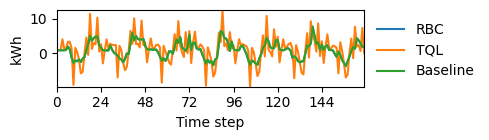

In [86]:
observations = tql_env.reset()

while not tql_env.done:
    actions = tql_model.predict(observations, deterministic=True)
    observations, _, _, _ = tql_env.step(actions)

# plot summary and compare with other control results
plot_simulation_summary({'RBC': rbc_env, 'TQL': tql_env})

In [87]:
def plot_table(
    ax: plt.Axes, table: np.ndarray, title: str, cmap: str,
    colorbar_label: str, xlabel: str, ylabel: str
) -> plt.Axes:
    """Plot 2-dimensional table on a heat map.

    Parameters
    ----------
    ax: plt.Axes
        Figure axes
    table: np.ndarray
        Table array
    title: str
        axes title
    cmap: str
        Colormap
    colorbar_label: str
        Colorbar name
    xlabel: str
        Heat map x-axis label
    ylabel: str
        Heat map y-axis label

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    x = list(range(table.shape[0]))
    y = list(range(table.shape[1]))
    z = table.T
    pcm = ax.pcolormesh(
        x, y, z, shading='nearest', cmap=cmap,
        edgecolors='black', linewidth=0.0
    )
    _ = fig.colorbar(
        pcm, ax=ax, orientation='horizontal',
        label=colorbar_label, fraction=0.025, pad=0.08
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return ax

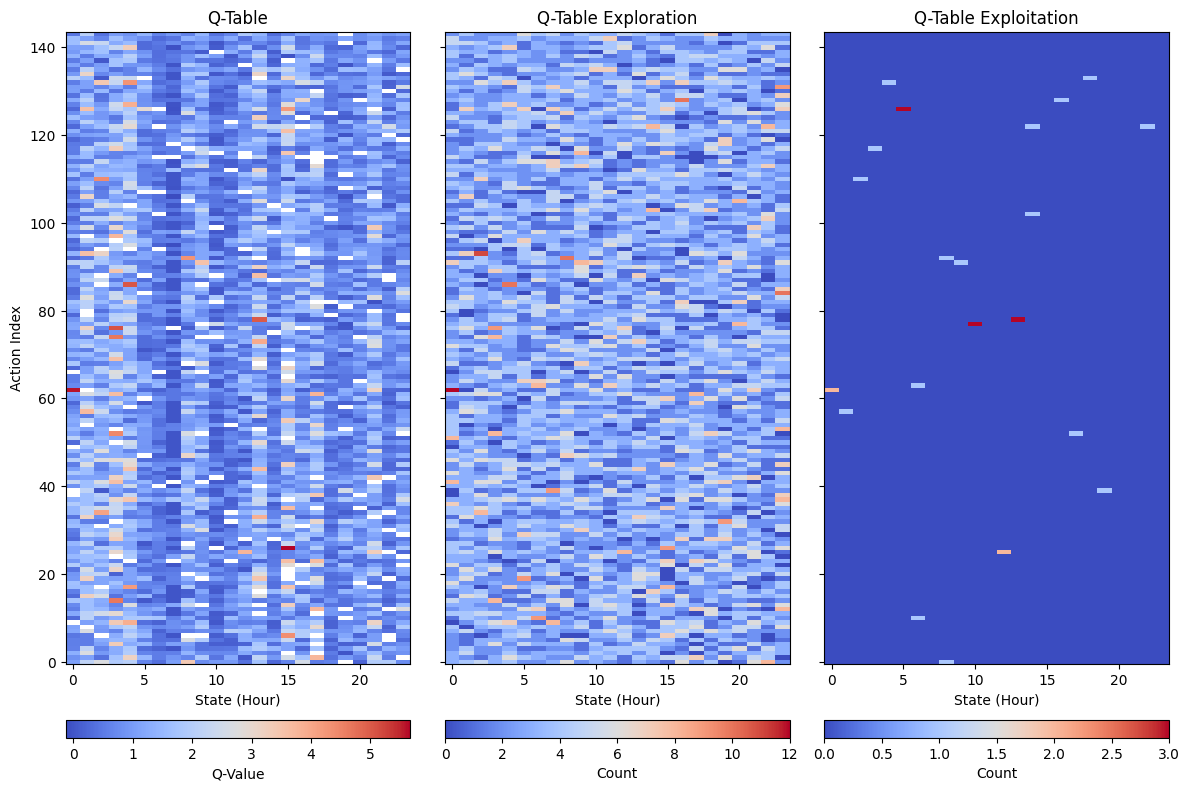

In [88]:
cmap = 'coolwarm'
figsize = (12, 8)
fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True)
axs[0] = plot_table(
    axs[0], tql_model.q[0], 'Q-Table',
    cmap, 'Q-Value', 'State (Hour)', 'Action Index'
)
axs[1] = plot_table(
    axs[1], tql_model.q_exploration[0], 'Q-Table Exploration',
    cmap, 'Count', 'State (Hour)', None
)
axs[2] = plot_table(
    axs[2], tql_model.q_exploitation[0], 'Q-Table Exploitation',
    cmap, 'Count', 'State (Hour)', None
)

plt.tight_layout()
plt.show()

In [89]:
print(
    f'Current Tabular Q-Learning epsilon after {tql_episodes}'\
        f' episodes and {tql_model.time_step} time steps:', tql_model.epsilon
)

Current Tabular Q-Learning epsilon after 62 episodes and 10521 time steps: 0.9938191803401585


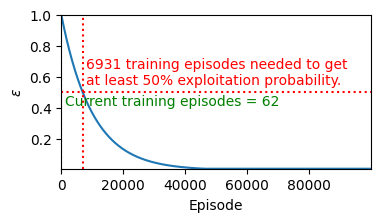

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
y = np.array([max(
    tql_model.minimum_epsilon,
    tql_model.epsilon_init*np.exp(-tql_model.epsilon_decay*e)
) for e in range(100_000)])
ref_x = len(y) - len(y[y <= 0.5]) - 1
ref_y = y[ref_x]
ax.plot(y)
ax.axvline(ref_x, color='red', linestyle=':')
ax.axhline(ref_y, color='red', linestyle=':')
ax.axvline(tql_episodes, color='green', linestyle=':')
ax.set_xlabel('Episode')
text = f'{ref_x} training episodes needed to get\nat least 50%'\
    ' exploitation probability.'
ax.text(ref_x + 1000, ref_y + 0.05, text, color='red')
ax.text(
    tql_episodes + 1000,
    ref_y - 0.1,
    f'Current training episodes = {tql_episodes}',
    va='bottom', color='green'
)
ax.set_ylabel(r'$\epsilon$')
plt.show()

# Soft-Actor Critic Reinforcement Learning Controller (SAC)
---



In [91]:
sac_env = CityLearnEnv(schema)

In [92]:
sac_env = NormalizedObservationWrapper(sac_env)

In [93]:
sac_env = StableBaselines3Wrapper(sac_env)

In [94]:
sac_model = SAC(policy='MlpPolicy', env=sac_env, seed=RANDOM_SEED)

In [95]:
class CustomCallback(BaseCallback):
    def __init__(self, env: CityLearnEnv, loader: IntProgress):
        r"""Initialize CustomCallback.

        Parameters
        ----------
        env: Mapping[str, CityLearnEnv]
            CityLearn environment instance.
        loader: IntProgress
            Progress bar.
        """

        super().__init__(verbose=0)
        self.loader = loader
        self.env = env
        self.reward_history = [0]

    def _on_step(self) -> bool:
        r"""Called each time the env step function is called."""

        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.loader.value += 1

        return True

In [96]:
# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
fraction = 0.25
sac_episodes = int(tql_episodes*fraction)
print('Fraction of Tabular Q-Learning episodes used:', fraction)
print('Number of episodes to train:', sac_episodes)
sac_episode_timesteps = sac_env.time_steps - 1
sac_total_timesteps = sac_episodes*sac_episode_timesteps

# ------------------------------- SET LOADER ------------------------------
sac_loader = get_loader(max=sac_total_timesteps)
display(sac_loader)

# ------------------------------- TRAIN MODEL -----------------------------
sac_callback = CustomCallback(env=sac_env, loader=sac_loader)
sac_model = sac_model.learn(
    total_timesteps=sac_total_timesteps,
    callback=sac_callback
)

sac_rewards = sac_callback.reward_history[1:]  # removes first 0 inserted in callback


Fraction of Tabular Q-Learning episodes used: 0.25
Number of episodes to train: 15


IntProgress(value=0, description='Simulating:', max=2505, style=ProgressStyle(bar_color='maroon'))

Building-level KPIs:


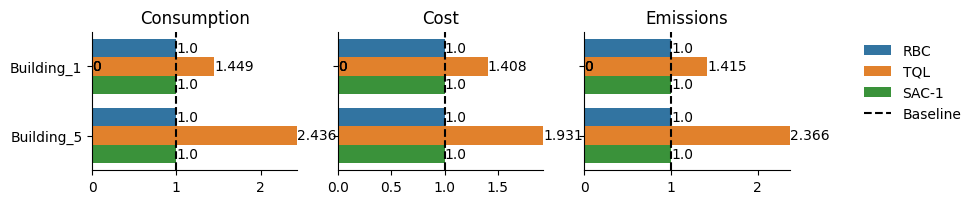

Building-level load profiles:


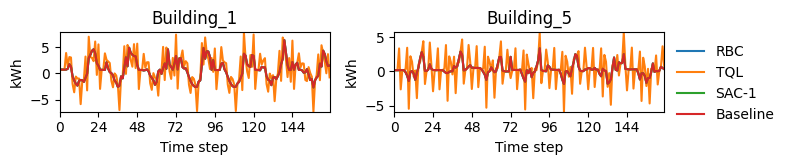

Battery SoC profiles:


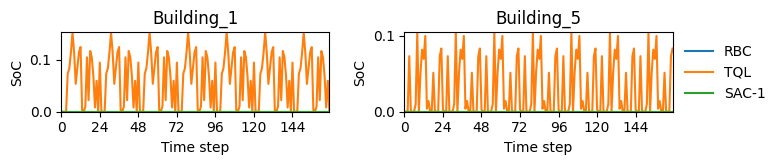

District-level KPIs:


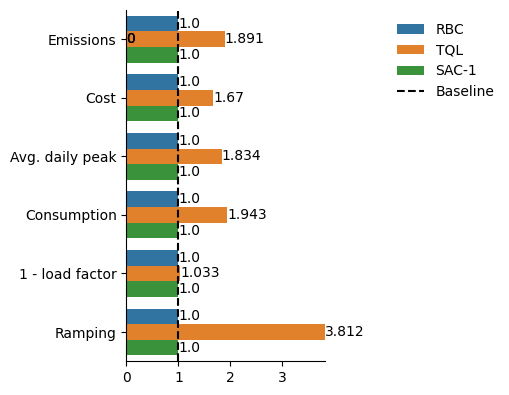

District-level load profiles:


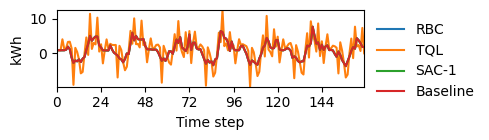

In [97]:
observations = sac_env.reset()
sac_actions_list = []

while not sac_env.done:
    actions, _ = sac_model.predict(observations, deterministic=True)
    observations, _, _, _ = sac_env.step(actions)
    sac_actions_list.append(actions)

# plot summary and compare with other control results
plot_simulation_summary({'RBC': rbc_env, 'TQL': tql_env, 'SAC-1': sac_env})

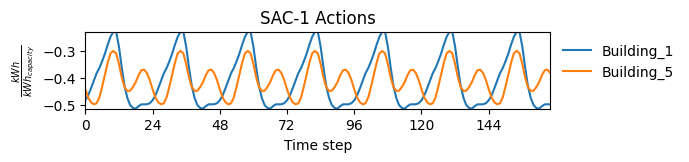

In [98]:
def plot_actions(actions_list: List[List[float]], title: str) -> plt.Figure:
    """Plots action time series for different buildings

    Parameters
    ----------
    actions_list: List[List[float]]
        List of actions where each element with index, i,
        in list is a list of the actions for different buildings
        taken at time step i.
    title: str
        Plot axes title

    Returns
    -------
    fig: plt.Figure
        Figure with plotted axes

    """

    fig, ax = plt.subplots(1, 1, figsize=(6, 1))
    columns = [b.name for b in sac_env.buildings]
    plot_data = pd.DataFrame(actions_list, columns=columns)
    x = list(range(plot_data.shape[0]))

    for c in plot_data.columns:
        y = plot_data[c].tolist()
        ax.plot(x, y, label=c)

    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    ax.set_xlabel('Time step')
    ax.set_ylabel(r'$\frac{kWh}{kWh_{capacity}}$')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(title)

    return fig

fig = plot_actions(sac_actions_list, 'SAC-1 Actions')
plt.show()

## Custom Reward Function



In [99]:
from typing import Any, List, Mapping, Union
from citylearn.reward_function import RewardFunction

class CustomReward(RewardFunction):
    r"""Initialize CustomReward.

    Parameters
    ----------
    env_metadata: Mapping[str, Any]
        General static information about the environment.
    """
    def __init__(self, env_metadata: Mapping[str, Any]):
        super().__init__(env_metadata)

    def calculate(
        self, observations: List[Mapping[str, Union[int, float]]]
    ) -> List[float]:
        r"""Returns reward for the most recent action.

        The reward is designed to minimize electricity cost.
        It is calculated for each building, *i*, and summed to provide the agent
        with a reward that is representative of all *n* buildings.
        It encourages net-zero energy use by penalizing grid load satisfaction
        when there is energy in the battery, as well as penalizing
        net export when the battery is not fully charged (through the penalty
        term). There is neither penalty nor reward when the battery
        is fully charged during net export to the grid. Whereas, when the
        battery is charged to capacity and there is net import from the
        grid, the penalty is maximized.

        Parameters
        ----------
        observations: List[Mapping[str, Union[int, float]]]
            List of all building observations at the current 
            :py:attr:`citylearn.citylearn.CityLearnEnv.time_step`
            (obtained by calling :py:meth:`citylearn.building.Building.observations`).

        Returns
        -------
        reward: List[float]
            Reward for the transition to the current timestep.
        """
        reward_list = []

        for o, m in zip(observations, self.env_metadata['buildings']):
            cost = o['net_electricity_consumption'] * o['electricity_pricing']
            battery_capacity = m['electrical_storage']['capacity']
            battery_soc = o.get('electrical_storage_soc', 0.0)
            penalty = -(1.0 + np.sign(cost) * battery_soc)
            reward = penalty * abs(cost)
            reward_list.append(reward)

        reward = [sum(reward_list)]
        return reward


In [100]:
# ----------------- INITIALIZE ENVIRONMENT -----------------
sacr_env = CityLearnEnv(schema)

# -------------------- SET CUSTOM REWARD -------------------
sacr_env.reward_function = CustomReward(sacr_env.get_metadata())

# -------------------- WRAP ENVIRONMENT --------------------
sacr_env = NormalizedObservationWrapper(sacr_env)
sacr_env = StableBaselines3Wrapper(sacr_env)

# -------------------- INITIALIZE AGENT --------------------
sacr_model = SAC(policy='MlpPolicy', env=sacr_env, seed=RANDOM_SEED)


# ----------------------- SET LOADER -----------------------
print('Number of episodes to train:', sac_episodes)
sac_modr_loader = get_loader(max=sac_total_timesteps)
display(sac_modr_loader)

# ----------------------- TRAIN AGENT ----------------------
sacr_callback = CustomCallback(env=sacr_env, loader=sac_modr_loader)
sacr_model = sacr_model.learn(
    total_timesteps=sac_total_timesteps,
    callback=sacr_callback
)

Number of episodes to train: 15


IntProgress(value=0, description='Simulating:', max=2505, style=ProgressStyle(bar_color='maroon'))

Building-level KPIs:


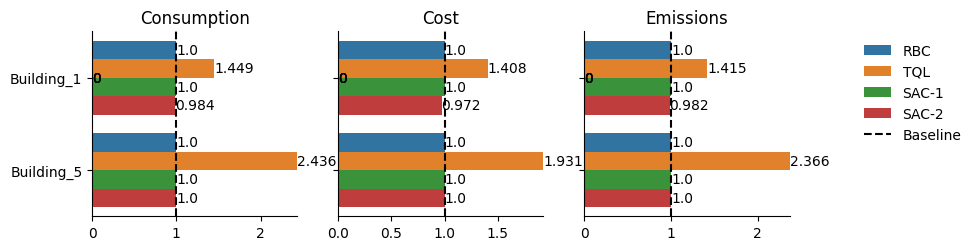

Building-level load profiles:


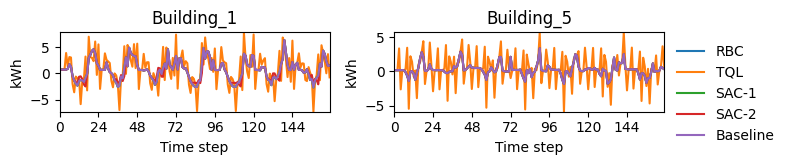

Battery SoC profiles:


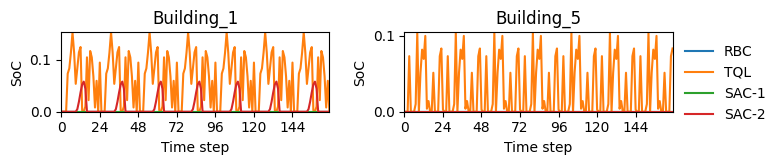

District-level KPIs:


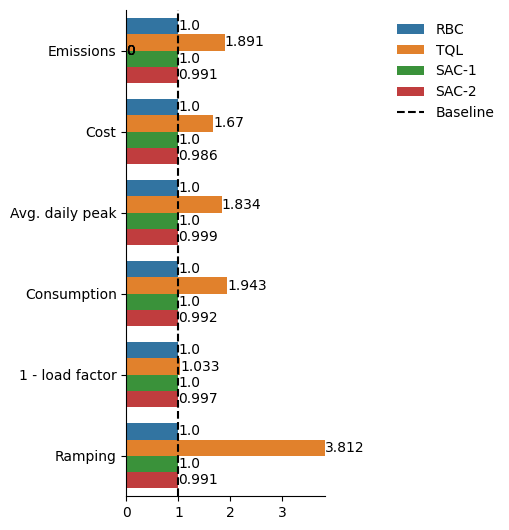

District-level load profiles:


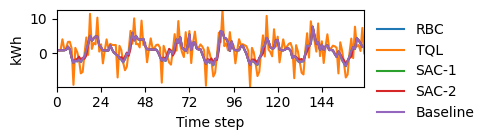

In [101]:
observations = sacr_env.reset()
sacr_actions_list = []

while not sacr_env.done:
    actions, _ = sacr_model.predict(observations, deterministic=True)
    observations, _, _, _ = sacr_env.step(actions)
    sacr_actions_list.append(actions)

plot_simulation_summary(
    {'RBC': rbc_env, 'TQL': tql_env, 'SAC-1': sac_env, 'SAC-2': sacr_env}
)

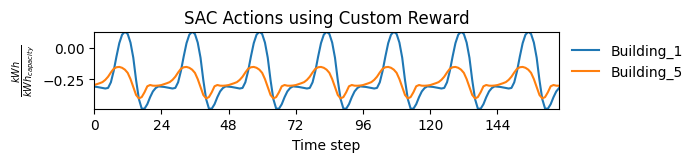

In [102]:
fig = plot_actions(sacr_actions_list, 'SAC Actions using Custom Reward')
plt.show()

In [103]:
def plot_rewards(ax: plt.Axes, rewards: List[float], title: str) -> plt.Axes:
    """Plots rewards over training episodes.

    Parameters
    ----------
    rewards: List[float]
        List of reward sum per episode.
    title: str
        Plot axes title

    Returns
    -------
    ax: plt.Axes
        Plotted axes
    """

    ax.plot(rewards)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    ax.set_title(title)

    return ax

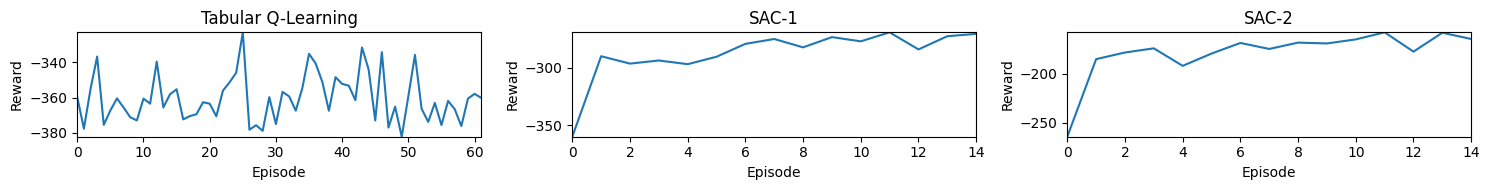

In [104]:
rewards = {
    'Tabular Q-Learning': tql_model.reward_history[:tql_episodes],
    'SAC-1': sac_callback.reward_history[:sac_episodes],
    'SAC-2': sacr_callback.reward_history[:sac_episodes]
}
fig, axs = plt.subplots(1, 3, figsize=(15, 2))

for ax, (k, v) in zip(fig.axes, rewards.items()):
    ax = plot_rewards(ax, v, k)

plt.tight_layout()
plt.show()

---

# 🧠 Soft Actor-Critic (SAC) Optimization for CityLearn Environment

This section implements the Soft Actor-Critic (SAC) algorithm, a model-free off-policy reinforcement learning method that combines the benefits of both value-based and policy-based approaches. SAC is particularly effective for continuous control tasks like building energy management in the CityLearn environment.

## 🔧 Implementation Overview

- **Algorithm**: Soft Actor-Critic (SAC)
- **Environment**: CityLearn with custom reward function
- **Training Episodes**: 1000 (optimized for convergence)
- **Seeds**: 5 different random seeds for robust evaluation
- **Wrappers**:
  - `NormalizedObservationWrapper`: Normalizes observations for stable training
  - `StableBaselines3Wrapper`: Ensures compatibility with SB3

## 🎯 Key Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| Policy | MlpPolicy | Multi-Layer Perceptron policy |
| Learning Rate | 3e-4 | Optimizer step size |
| Batch Size | 512 | Size of minibatches for training |
| Gamma (γ) | 0.99 | Discount factor for future rewards |
| Tau (τ) | 0.005 | Soft update coefficient for target networks |
| Entropy Coefficient | Auto-tuned | Balances exploration/exploitation |

## 📊 Training Process

1. **Environment Setup**:
   - Initialize CityLearn environment with specified schema
   - Apply observation normalization
   - Set up SB3 compatibility

2. **Model Configuration**:
   - Initialize SAC with specified hyperparameters
   - Set random seeds for reproducibility
   - Configure custom callback for reward tracking

3. **Training Loop**:
   - Run for specified number of episodes
   - Save model checkpoints and reward history
   - Track progress with visual feedback

4. **Output**:
   - Save trained models
   - Log reward trajectories
   - Generate learning curves

## 💡 Key Features

- **Off-policy Learning**: Efficient sample reuse through experience replay
- **Entropy Regularization**: Automatically balances exploration and exploitation
- **Stable Training**: Uses target networks and soft updates
- **Reproducibility**: Multiple seeds for reliable evaluation

The code includes comprehensive progress tracking and automatically saves results for later analysis.

In [105]:
from stable_baselines3 import SAC
import numpy as np
import pandas as pd
import random
import os

seeds = [0, 1, 2, 3, 4]
fraction = 0.25
# sac_episodes = int(tql_episodes * fraction)
sac_episodes = 1000  # number of episodes for clear convergence to SAC stability

print(f'Number of episodes to train SAC: {sac_episodes}')

# To store all rewards
all_sac_rewards = []

# Training for each seed
for seed in seeds:
    print(f'\n🚀 Starting SAC training with seed {seed}')

    np.random.seed(seed)
    random.seed(seed)

    sac_env = CityLearnEnv(schema)
    sac_env.reward_function = CustomReward(sac_env.get_metadata())
    sac_env = NormalizedObservationWrapper(sac_env)
    sac_env = StableBaselines3Wrapper(sac_env)

    sac_episode_timesteps = sac_env.time_steps - 1
    sac_total_timesteps = sac_episodes * sac_episode_timesteps

    sac_loader = get_loader(max=sac_total_timesteps)
    display(sac_loader)

    sac_callback = CustomCallback(env=sac_env, loader=sac_loader)

    sac_model = SAC(
        policy='MlpPolicy',
        env=sac_env,
        seed=seed,
        learning_rate=3e-4,
        batch_size=512,
        gamma=0.99,
        tau=0.005,
        verbose=0
    )

    sac_model.learn(
        total_timesteps=sac_total_timesteps,
        callback=sac_callback
    )

    rewards = pd.Series(sac_callback.reward_history[1:])  # remove initial reward = 0
    all_sac_rewards.append(rewards)

    rewards.to_csv(f'results/sac_rewards_seed{seed}.csv', index=False)
    print(f'✅ Seed {seed} complete — results saved')

Number of episodes to train SAC: 1000

🚀 Starting SAC training with seed 0


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 0 complete — results saved

🚀 Starting SAC training with seed 1


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 1 complete — results saved

🚀 Starting SAC training with seed 2


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 2 complete — results saved

🚀 Starting SAC training with seed 3


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 3 complete — results saved

🚀 Starting SAC training with seed 4


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 4 complete — results saved


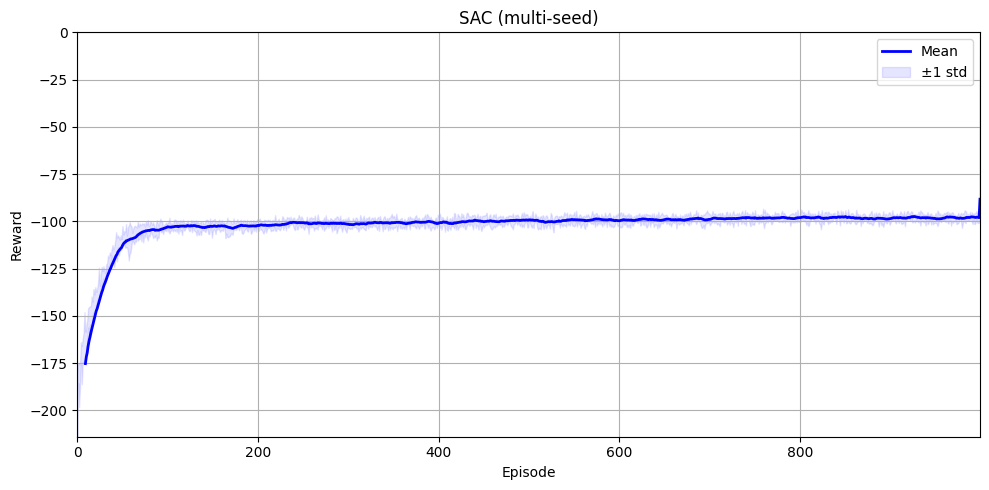

In [106]:
import matplotlib.pyplot as plt

# Calculate mean and standard deviation of rewards per episode
df_sac_all = pd.concat(all_sac_rewards, axis=1)
df_sac_all.columns = [f'Seed {s}' for s in seeds]

reward_mean = df_sac_all.mean(axis=1)
reward_std = df_sac_all.std(axis=1)
reward_smoothed = reward_mean.rolling(window=10).mean()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(reward_smoothed, color='blue', linewidth=2, label='Mean')

# ±1 standard deviation bands
ax.fill_between(
    reward_mean.index,
    reward_mean - reward_std,
    reward_mean + reward_std,
    color='blue',
    alpha=0.1,
    label='±1 std'
)

# Labels and layout
ax.set_title('SAC (multi-seed)')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# 🧠 Proximal Policy Optimization (PPO) for CityLearn Environment

This code implements the Proximal Policy Optimization (PPO) algorithm, a policy gradient method that's particularly effective for continuous control tasks in the CityLearn environment.

## 🔧 Implementation Overview

- **Algorithm**: Proximal Policy Optimization (PPO)
- **Environment**: CityLearn with custom reward function
- **Training Episodes**: 1000
- **Seeds**: 5 different random seeds for robust evaluation
- **Wrappers**:
  - `NormalizedObservationWrapper`: Normalizes observations for stable training
  - `StableBaselines3Wrapper`: Ensures compatibility with SB3

## 🎯 Key Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| Policy | MlpPolicy | Multi-Layer Perceptron policy |
| Learning Rate | 3e-4 | Optimizer step size |
| Batch Size | 64 | Size of minibatches for training |
| N Steps | 1024 | Number of steps per update |
| N Epochs | 10 | Number of epochs for optimization |
| Gamma (γ) | 0.99 | Discount factor for future rewards |
| Clip Range | 0.2 | Clipping parameter for policy updates |
| Entropy Coefficient | 0.01 | Encourages exploration |
| Target KL | 0.05 | Maximum KL divergence between updates |

## 📊 Training Process

1. **Environment Setup**:
   - Initialize CityLearn environment with specified schema
   - Apply observation normalization
   - Set up SB3 compatibility

2. **Model Configuration**:
   - Initialize PPO with specified hyperparameters
   - Set random seeds for reproducibility
   - Configure custom callback for reward tracking

3. **Training Loop**:
   - Run for specified number of episodes
   - Save model checkpoints and reward history
   - Track progress with visual feedback

4. **Output**:
   - Save trained models
   - Log reward trajectories
   - Generate learning curves

## 💡 Key Features

- **Trust Region Updates**: Uses clipping to ensure stable policy updates
- **Multiple Epochs**: Reuses samples for multiple gradient steps
- **Entropy Regularization**: Balances exploration and exploitation
- **Reproducibility**: Multiple seeds for reliable evaluation

The code includes comprehensive progress tracking and automatically saves results for later analysis.

## 🏁 Environment and Wrapper Initialization

In [107]:
from stable_baselines3 import PPO            #Imports PPO algorithm from SB3

# ppo_env = CityLearnEnv(schema)               #Creates CityLearn env with same schema
# ppo_env = NormalizedObservationWrapper(ppo_env)        #Normalization of observations, as is done with SAC
# ppo_env = StableBaselines3Wrapper(ppo_env)             #Wrapper SB3 for compatibility

### 📊 Interpretation of PPO Training Parameters

| Section        | Key                | Meaning                                                                                   |
|----------------|-----------------------|-----------------------------------------------------------------------------------------------|
| **rollout/**   | `ep_len_mean`         | Average episode length (in steps). Full episodes: the entire simulated year has been used → ✅ |
|                | `ep_rew_mean`         | Average reward per episode (expected value: should improve, ideally trend toward zero)       |
| **time/**      | `fps`                 | Frames per second (simulation speed)                                                |
|                | `iterations`          | Total number of updates (one every n_steps)                                      |
|                | `time_elapsed`        | Total training time (in seconds) ⏱️                                                    |
|                | `total_timesteps`     | Total number of simulated steps (episodes × steps per episode)                               |
| **train/**     | `approx_kl`           | KL divergence between old and new policy (lower is better → more stable updates)  |
|                | `clip_fraction`       | Percentage of clipped updates (outside threshold)                                                 |
|                | `clip_range`          | Maximum allowed range for policy updates                                             |
|                | `entropy_loss`        | Entropy loss (how “random” the policy is; large negative values = more deterministic) 🎲 |
|                | `explained_variance`  | Variance explained by the value function vs. the target (higher = more accurate value network)   |
|                | `learning_rate`       | Learning rate. 0.0001 is considered a **very stable** value 📉                                |
|                | `loss`                | Total loss (sum of policy loss and value loss)                                          |
|                | `n_updates`           | Total number of policy/value updates                                                  |
|                | `policy_gradient_loss`| How much the policy has been updated (gradient of the loss)                                   |
|                | `std`                 | Standard deviation of sampled actions (low = less exploration)                      |
|                | `value_loss`          | Value function error (lower is better)                                          |


In [108]:
from stable_baselines3 import PPO
import numpy as np
import pandas as pd
import random
import os

seeds = [0, 1, 2, 3, 4]
ppo_episodes = 1000
print(f'Number of episodes to train PPO: {ppo_episodes}')

# Create directories if they don't exist
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

all_ppo_rewards = []

for seed in seeds:
    print(f'\n🚀 Starting PPO training with seed {seed}')

    np.random.seed(seed)
    random.seed(seed)

    # Initialize environment and wrapper
    env = CityLearnEnv(schema)
    env.reward_function = CustomReward(env.get_metadata())
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)

    # Calculate timesteps
    episode_timesteps = env.time_steps - 1
    total_timesteps = ppo_episodes * episode_timesteps

    loader = get_loader(max=total_timesteps)
    display(loader)
    callback = CustomCallback(env=env, loader=loader)

    model = PPO(
        policy='MlpPolicy',
        env=env,
        seed=seed,
        learning_rate=3e-4,
        n_steps=1024,
        batch_size=64,
        n_epochs=10,
        clip_range=0.2,
        ent_coef=0.01,
        target_kl=0.05,
        normalize_advantage=True,
        verbose=0
    )

    model.learn(
        total_timesteps=total_timesteps,
        callback=callback
    )

    rewards = pd.Series(callback.reward_history[:ppo_episodes])
    all_ppo_rewards.append(rewards)

    rewards.to_csv(f'results/ppo_rewards_seed{seed}.csv', index=False)
    model.save(f'models/ppo_model_seed{seed}')

    print(f'✅ Seed {seed} complete — results saved')

Number of episodes to train PPO: 1000

🚀 Starting PPO training with seed 0


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 0 complete — results saved

🚀 Starting PPO training with seed 1


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 1 complete — results saved

🚀 Starting PPO training with seed 2


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 2 complete — results saved

🚀 Starting PPO training with seed 3


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 3 complete — results saved

🚀 Starting PPO training with seed 4


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 4 complete — results saved


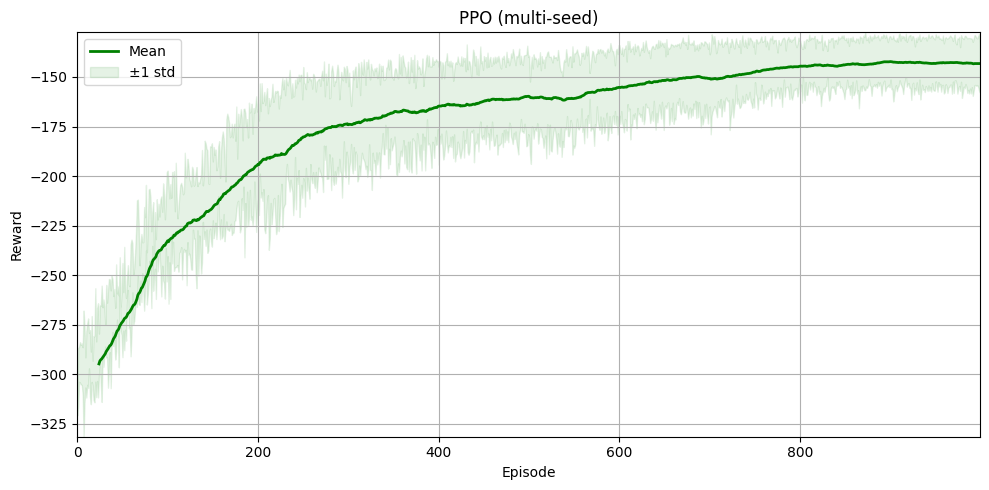

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine reward history from all seeds into a DataFrame
df_ppo_all = pd.concat(all_ppo_rewards, axis=1)
df_ppo_all.columns = [f'Seed {s}' for s in seeds]

# Calculate mean and standard deviation
ppo_mean = df_ppo_all.mean(axis=1)
ppo_std = df_ppo_all.std(axis=1)
ppo_smoothed = ppo_mean.rolling(window=25).mean()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# (Optional) Plot raw rewards for each seed
# for i, seed in enumerate(seeds):
#     ax.plot(df_ppo_all.iloc[:, i], alpha=0.2, label=f'Seed {seed}')

ax.plot(ppo_smoothed, color='green', linewidth=2, label='Mean')

# ±1 standard deviation bands
ax.fill_between(
    ppo_mean.index,
    ppo_mean - ppo_std,
    ppo_mean + ppo_std,
    color='green',
    alpha=0.1,
    label='±1 std'
)

# Labels and layout
ax.set_title('PPO (multi-seed)')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# 🧠 Twin Delayed DDPG (TD3) for CityLearn Environment

This code implements the Twin Delayed DDPG (TD3) algorithm, an advanced off-policy method for continuous control in the CityLearn environment. TD3 improves upon DDPG by addressing function approximation errors through twin Q-networks and delayed policy updates.

## 🔧 Implementation Overview

- **Algorithm**: Twin Delayed DDPG (TD3)
- **Environment**: CityLearn with custom reward function
- **Training Episodes**: 1000
- **Seeds**: 5 different random seeds for robust evaluation
- **Device**: Automatically uses GPU if available, falls back to CPU
- **Wrappers**:
  - `NormalizedObservationWrapper`: Normalizes observations for stable training
  - `StableBaselines3Wrapper`: Ensures compatibility with SB3

## 🎯 Key Hyperparameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| Policy | MlpPolicy | Multi-Layer Perceptron policy |
| Learning Rate | 1e-3 | Optimizer step size |
| Batch Size | 128 | Size of minibatches for training |
| Buffer Size | 50,000 | Size of experience replay buffer |
| Tau (τ) | 0.001 | Soft update coefficient for target networks |
| Gamma (γ) | 0.99 | Discount factor for future rewards |
| Policy Delay | 2 | Frequency of policy updates relative to Q-functions |
| Target Noise | 0.2 | Stddev of noise added to target actions |
| Noise Clip | 0.3 | Range for clipping target noise |

## 📊 Training Process

1. **Environment Setup**:
   - Initialize CityLearn environment with specified schema
   - Apply observation normalization
   - Set up SB3 compatibility

2. **Exploration Strategy**:
   - Uses NormalActionNoise for exploration
   - Noise parameters: mean=0, sigma=0.1

3. **Model Configuration**:
   - Twin Q-networks to prevent overestimation
   - Delayed policy updates for stability
   - Experience replay buffer for sample efficiency

4. **Training Loop**:
   - Runs for specified number of episodes
   - Saves model checkpoints and reward history
   - Tracks progress with visual feedback

5. **Output**:
   - Saves trained models
   - Logs reward trajectories
   - Clears GPU cache between seeds

## 💡 Key Features

- **Twin Q-Networks**: Reduces overestimation bias
- **Delayed Updates**: Improves stability by updating policy less frequently
- **Target Policy Smoothing**: Adds noise to target actions
- **GPU Acceleration**: Automatically utilizes available GPU resources
- **Reproducibility**: Multiple seeds for reliable evaluation
- **Memory Management**: Clears GPU cache between training runs

The code includes comprehensive progress tracking and automatically saves results for later analysis.

In [111]:
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Training parameters
td3_episodes = 1000
print('Number of episodes to train TD3:', td3_episodes)

# Multi-seed setup
seeds = [0, 1, 2, 3, 4]
all_td3_rewards = []

for seed in seeds:
    print(f"\n=== Training TD3 with seed {seed} ===")

    # Initialize CityLearn environment
    td3_env = CityLearnEnv(schema)
    td3_env.reward_function = CustomReward(td3_env.get_metadata())  # Align TD3 reward signal with SAC/PPO
    td3_env = NormalizedObservationWrapper(td3_env)
    td3_env = StableBaselines3Wrapper(td3_env)

    # Exploration noise
    n_actions = td3_env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.1 * np.ones(n_actions)
    )

    # Calculate total timesteps
    td3_episode_timesteps = td3_env.time_steps - 1
    td3_total_timesteps = td3_episodes * td3_episode_timesteps

    # Progress bar loader
    td3_loader = get_loader(max=td3_total_timesteps)
    display(td3_loader)

    # Callback for tracking rewards
    td3_callback = CustomCallback(env=td3_env, loader=td3_loader)

    # TD3 model
    td3_model = TD3(
        policy='MlpPolicy',
        env=td3_env,
        seed=seed,
        learning_rate=1e-3,
        buffer_size=50_000,
        batch_size=128,
        tau=0.001,
        gamma=0.99,
        train_freq=(1, 'step'),
        gradient_steps=1,
        learning_starts=1000,
        policy_delay=2,
        target_policy_noise=0.2,
        target_noise_clip=0.3,
        action_noise=action_noise,
        verbose=0,
        device=device,
        policy_kwargs=dict(
            net_arch=dict(pi=[256, 256], qf=[256, 256]),  # Network architecture
            activation_fn=torch.nn.ReLU,
            n_critics=2
        )
    )

    # Training
    td3_model.learn(
        total_timesteps=td3_total_timesteps,
        callback=td3_callback
    )

    # Save rewards
    current_seed_rewards = pd.Series(td3_callback.reward_history)
    all_td3_rewards.append(current_seed_rewards)

    current_seed_rewards.to_csv(f'results/td3_rewards_seed{seed}.csv', index=False)
    td3_model.save(f'models/td3_model_seed{seed}')

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f'✅ Seed {seed} complete — results saved')

CUDA available: False
Number of GPUs: 0
Using device: cpu
Number of episodes to train TD3: 1000

=== Training TD3 with seed 0 ===


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 0 complete — results saved

=== Training TD3 with seed 1 ===


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 1 complete — results saved

=== Training TD3 with seed 2 ===


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 2 complete — results saved

=== Training TD3 with seed 3 ===


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 3 complete — results saved

=== Training TD3 with seed 4 ===


IntProgress(value=0, description='Simulating:', max=167000, style=ProgressStyle(bar_color='maroon'))

✅ Seed 4 complete — results saved


In [112]:
# Create DataFrame with rewards from each seed
df_all_td3 = pd.concat(all_td3_rewards, axis=1)
df_all_td3.columns = [f'Seed {s}' for s in seeds]

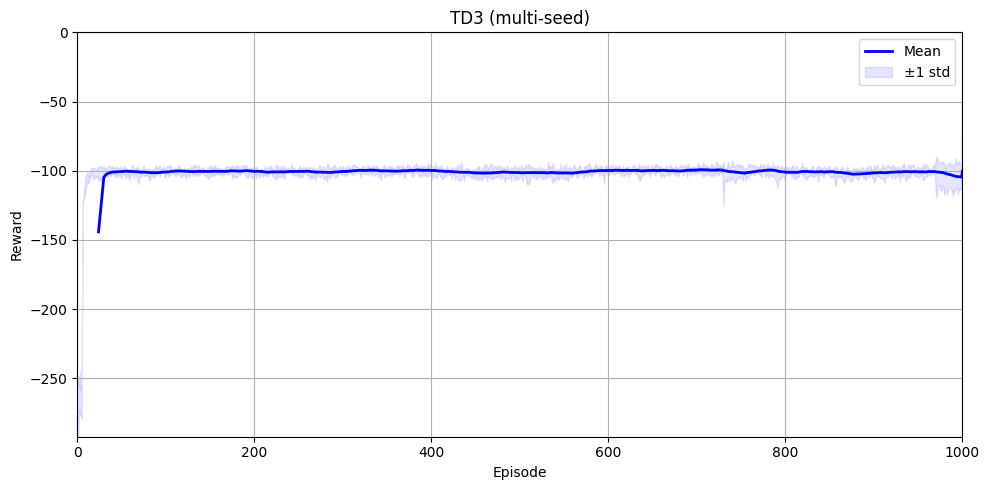

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine reward history from all seeds into a DataFrame
df_td3_all = pd.concat(all_td3_rewards, axis=1)
df_td3_all.columns = [f'Seed {s}' for s in seeds]

# Calculate mean and standard deviation
td3_mean = df_td3_all.mean(axis=1)
td3_std = df_td3_all.std(axis=1)
td3_smoothed = td3_mean.rolling(window=25).mean()

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# (Optional) Plot raw rewards for each seed
# for i, seed in enumerate(seeds):
#     ax.plot(df_td3_all.iloc[:, i], alpha=0.2, label=f'Seed {seed}')

ax.plot(td3_smoothed, color='blue', linewidth=2, label='Mean')

# Add ±1 standard deviation bands
ax.fill_between(
    td3_mean.index,
    td3_mean - td3_std,
    td3_mean + td3_std,
    color='blue',
    alpha=0.1,
    label='±1 std'
)

# Configure plot labels and layout
ax.set_title('TD3 (multi-seed)')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# 📊 Performance Comparison: SAC vs PPO vs TD3

This code generates a comparative visualization of the training performance across three reinforcement learning algorithms: SAC, PPO, and TD3. The plot provides insights into the learning dynamics and stability of each algorithm.

## 🔍 What the Code Does:

1. **Data Preparation**:
   - Expects three DataFrames (`df_sac_all`, `df_ppo_all`, `df_td3_all`), each containing results from 5 different random seeds
   - Each column represents the reward trajectory from a different seed

2. **Statistical Analysis**:
   - Computes mean and standard deviation across seeds for each algorithm
   - Applies a rolling average (window=25) to smooth the learning curves
   - Handles confidence intervals using ±1 standard deviation

3. **Visualization**:
   - Plots smoothed mean reward curves for SAC (blue), PPO (green), and TD3 (orange)
   - Adds semi-transparent bands showing the standard deviation across seeds
   - Includes proper labels, title, grid, and legend for clarity

## 📈 Key Features:

- **Multi-seed Analysis**: Shows both central tendency and variance across different random initializations
- **Smoothed Curves**: Uses rolling average to highlight overall trends
- **Confidence Intervals**: Visualizes algorithm stability through standard deviation bands
- **Comparison**: Enables direct performance comparison between the three algorithms

The resulting plot helps evaluate:
- Which algorithm converges faster
- Which algorithm achieves higher rewards
- The stability of each algorithm across different random seeds
- The variance in performance between different runs

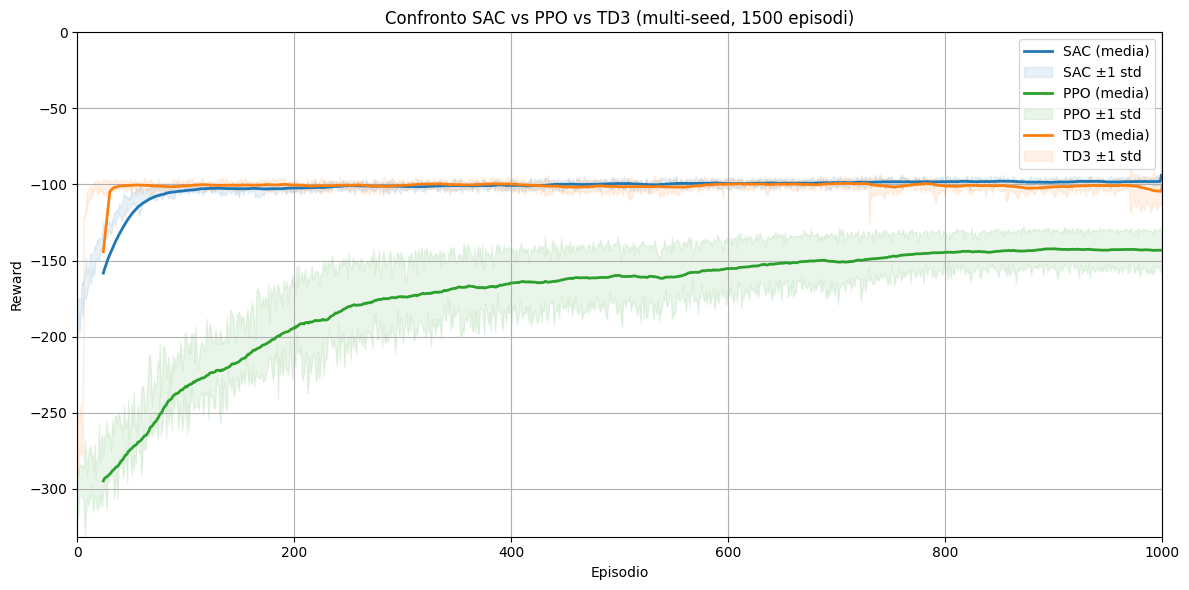

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

# === INPUT ===
# Assicurati che i seguenti DataFrame esistano e contengano 5 colonne (1 per seed):
# df_sac_all, df_ppo_all, df_td3_all

# Funzione di utilità per calcolare media, std e smoothing
def compute_stats(df, window=25):
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    smoothed = mean.rolling(window=window).mean()
    return mean, std, smoothed

# Calcolo statistiche
sac_mean, sac_std, sac_smooth = compute_stats(df_sac_all)
ppo_mean, ppo_std, ppo_smooth = compute_stats(df_ppo_all)
td3_mean, td3_std, td3_smooth = compute_stats(df_td3_all)

# === PLOT ===
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# SAC
ax.plot(sac_smooth, label='SAC (media)', linewidth=2, color='tab:blue')
ax.fill_between(sac_mean.index, sac_mean - sac_std, sac_mean + sac_std,
                alpha=0.1, color='tab:blue', label='SAC ±1 std')

# PPO
ax.plot(ppo_smooth, label='PPO (media)', linewidth=2, color='tab:green')
ax.fill_between(ppo_mean.index, ppo_mean - ppo_std, ppo_mean + ppo_std,
                alpha=0.1, color='tab:green', label='PPO ±1 std')

# TD3
ax.plot(td3_smooth, label='TD3 (media)', linewidth=2, color='tab:orange')
ax.fill_between(td3_mean.index, td3_mean - td3_std, td3_mean + td3_std,
                alpha=0.1, color='tab:orange', label='TD3 ±1 std')

# Layout
ax.set_title('Confronto SAC vs PPO vs TD3 (multi-seed, 1500 episodi)')
ax.set_xlabel('Episodio')
ax.set_ylabel('Reward')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


---

NEW REWARD